## Imports

In [105]:
# Use this cell to regroup all your imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ydata_profiling import ProfileReport
from itertools import product

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import csv
import optuna

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# 🏆 Le Wagon Kaggle Batch Challenge

**Welcome to your first Kaggle competition!**

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/ML/kaggle-batch-challenge.png' width=600>

Your objective is to **submit an answer (online)** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 🏠

Fortunately, you have already come across the housing dataset earlier in the bootcamp! You will be semi-guided toward a **baseline model**, and only after creating a baseline will you be free to improve and refine it. We will approach the problem using **pipelines** (the best practice)!

A few words on Kaggle:
- Kaggle will rank your submission amongst all participants!
- Everyone is removed from the public leaderboard after 2 months
- You can make up to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- Collapse all headings from the command palette (`Cmd + Shift + P`)
- Stay  "idempotent" (`Restart & Run All` should never crash)
- Name and delete variables carefully

## Kaggle Setup

👉 Create an account on Kaggle if you want to participate in the competition

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` in the [results spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0); if you can't find your batch, reach out to your teacher!

**The whole batch will compete as a group against the team of TAs**

## Loading Data

In the challenge instructions, you should have already executed the steps to download everything you need from Kaggle into your current notebook folder:

- `train.csv` is your `(1460, 81)` training set containing `X` and `y`
- `test.csv` is your `(1459, 80)` testing set without the associated target `y` 😈
- `sample_submission.csv` describes the format required to submit your answer

ℹ️ You'll find a detailed description of the dataset [here](https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/07-Ensemble-Methods/kaggle_houses_data_description.txt). Refer to it throughout the challenge!

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your `test_score` and ranking

❓ Load the training dataset into a DataFrame called `data`, and create your `X` and `y`. Inspect their shapes.

**Hint:** if you check the CSV file, you will notice a column called `Id`. When reading the CSV file into a DF, make sure to set `index_col="Id"` so that you don't get two ID columns 😉

In [2]:
url = ('data/train.csv')
data = pd.read_csv(url, index_col="Id")

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
drop_cats = ['BsmtFullBath',
 'GarageCars',
 'GrLivArea',
 'HalfBath',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd',
'SalePrice']

In [4]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features are too much to deal with one by one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [5]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

❓ Create a Series called `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total?

In [6]:
feat_categorical_nunique = X.select_dtypes(include='object').nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with a maximum of ~50 features (📚 read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
1. **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model; this may require statistical analysis of feature importance
2. **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot encode) categorical features into integers; this, however, creates a notion of "order" (1 > 2 > 3 > ...) that can be detrimental if not handled properly!

❓ Plot the **histogram** of the number of unique values per categorical feature. Do you see some quick wins?

In [7]:
feat_categorical_small = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition']

💡 As a starting point, what about simply **removing** all features that have **7 unique values or more**, and one-hot encoding the rest? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store the names of the features to be OHE'd in a list called `feat_categorical_small` below. How many features will be OHE'd?

In [37]:
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 6]
feat_categorical_small

MSZoning        5
Street          2
Alley           2
LotShape        4
LandContour     4
Utilities       2
LotConfig       5
LandSlope       3
BldgType        5
MasVnrType      4
ExterQual       4
ExterCond       5
BsmtQual        4
BsmtCond        4
BsmtExposure    4
HeatingQC       5
CentralAir      2
Electrical      5
KitchenQual     4
FireplaceQu     5
GarageFinish    3
GarageQual      5
GarageCond      5
PavedDrive      3
PoolQC          3
Fence           4
MiscFeature     4
dtype: int64

In [9]:
feature_categorical = X.select_dtypes(include='object')

# unique_values_dict = {cat: unique_cats[cat] for cat in feat_categorical_small.index if cat in unique_cats}

# unique_values_dict

## 1.2 Baseline Pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features:
- Simple-Impute with the most frequent values
- One-Hot Encode features that have less than 7 unique values to start with
- Drop all other features


As for numerical features:
- Simple-Impute with strategy `mean`
- Min-Max Scale


<details>
    <summary>ℹ️ Click here for a pro tip</summary>

If you are confident, you can try Sklearn's shorter-syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax of `Pipeline` or `ColumnTransformer`; also useful if you want to avoid giving names manually to every step.
</details>

In [12]:
# feat_categorical = X.select_dtypes(include='object').columns
# feat_numerical = X.select_dtypes(exclude='object').columns

cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), 
                                MinMaxScaler())

# cat_preproc = make_column_transformer((cat_transformer, make_column_selector(dtype_include=object)),
#                                        remainder = 'drop')

# num_preproc = make_column_transformer((num_transformer, make_column_selector(dtype_exclude=object)))

preproc_baseline = make_column_transformer(
                                    (cat_transformer, feat_categorical_small),
                                    (num_transformer, make_column_selector(dtype_exclude=object)),
                                    remainder = 'drop'
                                    )
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 MSZoning        5
Street          2
Alley           2
LotShape        4
LandContour     4
Utilities       2
LotConfig       5
LandSlope       3
BldgType        5
MasVnrType      4
ExterQual       4
ExterCond       5
BsmtQual        4
BsmtCond        4
BsmtExposure    4
HeatingQC       5
CentralAir      2
Electrical      5
KitchenQual     4
FireplaceQu     5
GarageFinish    3
GarageQual      5
GarageCond      5
PavedDrive      3
PoolQC          3
Fence           4
MiscFeature     4
dtype: int64),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f0533ce2ec0>)])

❓ Look at the **shape** of your preprocessed DataFrame and save it to `shape_preproc_baseline`

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preproc_baseline_df = pd.DataFrame(preproc_baseline.fit_transform(X), columns=preproc_baseline.get_feature_names_out())
shape_preproc_baseline = preproc_baseline_df.shape
preproc_baseline_df.head()

,pipeline-1__Alley_Grvl,pipeline-1__Alley_Pave,pipeline-1__LotFrontage_21.0,pipeline-1__LotFrontage_24.0,pipeline-1__LotFrontage_30.0,pipeline-1__LotFrontage_32.0,pipeline-1__LotFrontage_33.0,pipeline-1__LotFrontage_34.0,pipeline-1__LotFrontage_35.0,pipeline-1__LotFrontage_36.0,...,pipeline-2__GarageArea,pipeline-2__WoodDeckSF,pipeline-2__OpenPorchSF,pipeline-2__EnclosedPorch,pipeline-2__3SsnPorch,pipeline-2__ScreenPorch,pipeline-2__PoolArea,pipeline-2__MiscVal,pipeline-2__MoSold,pipeline-2__YrSold
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


In [14]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'preproc_baseline',
    shape=shape_preproc_baseline
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /root/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /root/code/krystiaL/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 1 item

test_preproc_baseline.py::TestPreprocBaseline::test_shape FAILED         [100%]

=================================== FAILURES ===================================
________________________ TestPreprocBaseline.test_shape ________________________

self = <test_preproc_baseline.TestPreprocBaseline testMethod=test_shape>

    def test_shape(self):
>       self.assertEqual(self.result.shape, (1460,183))
E       AssertionError: Tuples differ: (1460, 4806) != (1460, 183)
E       
E       First differing element 1:
E       4806
E       183
E       
E       - (1460, 4806)
E       ?        ^ ^

In [15]:
!git add tests/preproc_baseline.pickle

!git commit -m 'Completed preproc_baseline step'

!git push origin master

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   houses_kaggle_competition.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	data/train.html

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


### b) Add Estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [16]:
pipe_baseline = make_pipeline(preproc_baseline, 
                             DecisionTreeRegressor()
                             )

pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  MSZoning        5
Street          2
Alley           2
LotShape        4
LandContour     4
Utilities       2
LotConfig       5
LandSlope       3
BldgType        5
MasVnrType      4
ExterQual       4
ExterCond       5
B...
Electrical      5
KitchenQual     4
FireplaceQu     5
GarageFinish    3
GarageQual      5
GarageCond      5
PavedDrive      3
PoolQC          3
Fence           4
MiscFeature     4
dtype: int64),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0533ce2ec0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation). Which performance metric do you need? Is it readily available in Sklearn?

Sadly, it isn't! We will need to create our custom `sklearn.metrics.scorer` object to pass to any cross-validation or Grid Search. The process is described below:


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 😉
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [17]:
def rmsle(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t)-np.log(1+p)
    rmsle = ((log_error**2).mean())**0.5
    return rmsle

rmsle = make_scorer(rmsle, greater_is_better=True)
rmsle_neg = make_scorer(rmsle)

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [18]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.20674570224098518

### d) Predict Baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [19]:
test_url = 'data/test.csv'
test_data = pd.read_csv(test_url)

pipe_baseline.fit(X, y)
predict_baseline = pipe_baseline.predict(test_data)
predict_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': predict_baseline})

# predict_df.insert(0, 'Id', reset_test['Id'])

In [20]:
# predict_df = predict_df.rename(columns={0: "SalePrice"})
# predict_df = predict_df['Id'].astype(np.int64)

❓ Finally, store your ready-to-submit CSV as `submission_baseline.csv` in the `data` folder. **Carefully read** and understand Kaggle's required format and test it below (you don't need to submit this baseline to Kaggle for now).

In [21]:
# Specify the file path where you want to save the CSV file
file_path = 'data/submission_baseline.csv'

# Export to a CSV file
# np.savetxt(file_path, predict_df, delimiter=',')
predict_df.to_csv(file_path, index=False, header=True)

# Check the exported CSV file in the specified file path
print(f"DataFrame exported to {file_path}")

DataFrame exported to data/submission_baseline.csv


In [22]:
from nbresult import ChallengeResult

tmp = pd.read_csv("data/submission_baseline.csv")

result = ChallengeResult(
    'submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)

result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /root/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /root/code/krystiaL/05-ML/07-Ensemble-Methods/data-houses-kaggle-competition/tests
plugins: asyncio-0.19.0, typeguard-2.13.3, anyio-3.6.2
asyncio: mode=strict
collecting ... collected 4 items

test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.19s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baseline step'

git push origin master


In [23]:
!git add tests/submission_baseline.pickle

!git commit -m 'Completed submission_baseline step'

!git push origin master

[master c4b3ec9] Completed submission_baseline step
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 20 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 374 bytes | 374.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To github.com:krystiaL/data-houses-kaggle-competition.git
   eba553f..c4b3ec9  master -> master


# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation on having fully pipelined a baseline model! You will see now how much easier it is to iterate and improve performance 🚀

Now, your goal is to improve your prediction and submit it to Kaggle **at least 30 minutes before the Recap ⏳**

We have some suggestions for improvements below: **pick your battles** and **incrementally** improve your pipeline as you see fit!

**Estimators**

- Tree-based ensembles (a must-try today); probably the best suited for problems with many categorical features
- Stacking!
- XGBoost!

**Preprocessing** (once your first ensemble model works)

- **Ordinal Encoding** of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- **Statistical Feature Selection** to remove useless features (avoids overfitting and reduces training time)
- Predict `log(SalePrice)` instead?
- 🤷

## 2.1 Preprocessing Iteration ♲ 
**⚠️ Come back here only after you have iterated on your estimators in section 2.2 ⚠️**

⏩ Collapse me if I'm not in use!

### a) Ordinal Encoding (~1h)

❓ Look at the following feature. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that! Check it out below and make sure to understand how this works 👇

In [24]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** (of your choice)
- `preproc_nominal` to one-hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort your features alphabetically to avoid bad surprises
</details>

In [38]:
Alley_sorted = ['NA', 'Grvl', 'Pave'] 
LotShape_sorted = ['Reg', 'IR1', 'IR2', 'IR3']
LandContour_sorted= ['Lvl', 'Bnk', 'Low', 'HLS']
Utilities_sorted=['AllPub', 'NoSeWa']
LotConfig_sorted=['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'] 
LandSlope_sorted=['Gtl', 'Mod', 'Sev']
BldgType_sorted=['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']

MasVnrType_sorted=['None', 'Stone', 'BrkFace', 'BrkCmn'] 

ExterQual_sorted=['Po', 'Fa', 'TA', 'Gd', 'Ex']
ExterCond_sorted=['Po', 'Fa', 'TA', 'Gd', 'Ex']
BsmtQual_sorted=['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
BsmtCond_sorted=['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
BsmtExposure_sorted=['NA','No', 'Mn', 'Av', 'Gd']
HeatingQC_sorted=['Po', 'Fa', 'TA', 'Gd', 'Ex']
KitchenQual_sorted=['Po', 'Fa', 'TA', 'Gd', 'Ex']
FireplaceQu_sorted=['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
GarageFinish_sorted=['NA', 'Unf', 'RFn', 'Fin']
GarageQual_sorted=['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
GarageCond_sorted=['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']
PavedDrive_sorted=['N', 'P', 'Y']
PoolQC_sorted=['NA', 'Fa', 'TA', 'Gd', 'Ex']
Fence_sorted=['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

In [39]:
unique_cats = [Alley_sorted, LotShape_sorted, LandContour_sorted, Utilities_sorted,
              LotConfig_sorted, LandSlope_sorted, BldgType_sorted, MasVnrType_sorted, 
              ExterQual_sorted, ExterCond_sorted, BsmtQual_sorted, BsmtCond_sorted,
              BsmtExposure_sorted, HeatingQC_sorted, KitchenQual_sorted,
              FireplaceQu_sorted, GarageFinish_sorted, GarageQual_sorted, GarageCond_sorted, 
              PavedDrive_sorted, PoolQC_sorted, Fence_sorted]

categories = {cat: unique_cats[i] for i, cat in enumerate(feat_categorical_small.index) if i < len(unique_cats)}

In [27]:
#define ordinal features to ordinal encode
feat_ordinal = sorted(categories.keys())
feat_ordinal_values_sorted = [categories[i] for i in feat_ordinal]

ordinal_encoder = OrdinalEncoder(
                                categories=feat_ordinal_values_sorted,
                                dtype= np.int64,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1
                                )

preproc_ordinal = make_pipeline(
                                (SimpleImputer(strategy='constant',
                                               fill_value='NA')),
                                ordinal_encoder,
                                MinMaxScaler() 
                               )

In [28]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [29]:
# Define nominal features to one-hot-encode as the remaining ones (non-numerical, non-ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [30]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['BsmtFinType1', 'BsmtFinType2', 'Condition1',
                                  'Condition2', 'Exterior1st', 'Exterior2nd',
                                  'Fence', 'Foundation', 'Functional',
                                  'GarageType', 'Heating', 'HouseStyle',
                                  'MiscFeature', 'Neighborhood', 'PavedDrive',
                                  'PoolQC', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType'])])

In [31]:
X_preprocess = pd.DataFrame(preproc.fit_transform(X, y))
X_preprocess.shape

(1460, 220)

### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features to limit overfitting and shorten training time.  

🔥 We will make use of Sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you try **only Option 1 today**, to start with. Options 2 and 3 will be corrected in the Recap!

#### Option 1 (Recommended) - <font color=green>Univariate</font> Feature Selection
*based on their mutual information with target `y`*

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter out features that, taken individually, least explain your target!
- The statistical test we recommend passing to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 What is mutual information? Click here!</summary>

- [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) is a **statistical** distance between two probability distributions
- Correlation is a **linear** distance between two random variables
- Mutual Information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [this animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [186]:
preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=80, # keep only 25% of all features
)


preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)

preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f04d4f9c760>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('ordina...
                                                   'BsmtFinType2', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Fence',
                                                   'Foundation', 'Functional',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'MiscFeature',
                                                   'Neighborhood', 'PavedDrive',
                                                   'PoolQC', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=80,
                                  score_func=<function mutual_info_regression at 0x7f0534127a30>))])

In [47]:
percentile = np.arange(60,80)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [48]:
grid_preproc_params = {
    'selectpercentile__percentile': percentile
}

In [34]:
preproc.fit_transform(X, y)

array([[0.23529412, 0.15068493, 0.0334198 , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.20205479, 0.03879502, ..., 0.        , 0.        ,
        1.        ],
       [0.23529412, 0.1609589 , 0.04650728, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.29411765, 0.15410959, 0.03618687, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.1609589 , 0.03934189, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.18493151, 0.04037019, ..., 0.        , 0.        ,
        1.        ]])

#### Option 2 - <font color=green>Multivariate</font> Feature Selection
*based on their combined relationship with target `y`*

🤔 We want to remove features that do not help predict our target even when combined with all the others.

1️⃣ To do so, remember that we can use the [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) metric in combination with an estimator! It trains one pipe per feature to estimate which feature makes our performance score *decrease* the most when shuffling it randomly. These would be our most important features, which we don't want to remove.

The best thing is that `scikit-learn` allows you to integrate this methodology directly into your `preproc` pipeline thanks to the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) transformer; this will recursively remove the least important features according to the `cross_val_score`.

When you have many features, however, this process can take extremely long to train.

2️⃣ Alternatively, a faster way would be to make use of models that already output some measure of `feature_importance` when being fitted. For instance, trees with a Gini-based `feature_importance_`, or Lasso regressions with an L1 `coef_`. `scikit-learn` already has the [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that.

In [35]:
preproc_transformer_multi = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_selector_multi = SelectFromModel(
    tuned_forest,
    threshold = "median", # drop all multivariate features lower than the median correlation
)


preproc_multi = make_pipeline(
    preproc_transformer_multi,
    preproc_selector_multi,
)

preproc_multi

NameError: name 'tuned_forest' is not defined

In [ ]:
preproc_transformer_multi = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop"
)

preproc_feat_select = CustomFeatureSelector(num_corr_threshold=0.95)

preproc_select = make_pipeline(
    preproc_feat_select,
    preproc_transformer_multi,
)

preproc_select

#### Option 3 - <font color=green>Unsupervised</font> Selection?
*filter based only on the properties of `X`*

❓ A quick win is to remove features with the lowest variance. Think about it: a feature that only has one value is useless (and has a variance of 0).

Feel free to add a [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) to the end of your pipeline!

In [ ]:
def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop"
    )

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector
    )

    return preproc.fit_transform(X).shape[1]

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to visually check whether any **numerical** features almost entirely correlate with others
- Use `VIF` from `statsmodels` to check for features that have the highest multicollinearity

In [ ]:
cutoff_values = np.arange(0, 0.2, 0.01)

plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')

plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarly to others. Feel free to plot a heatmap again.

In [ ]:
corr_num = X[feat_numerical].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [ ]:
# Check which columns to drop based on high correlation 
num_corr_threshold = 0.95

corr_num = X[feat_numerical].corr()
corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()

num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
num_col_to_drop


❓ Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (Spearman + Pearson) correlation threshold; you'll need a custom transformer class.

In [ ]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))

sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1);

In [ ]:
class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_corr_threshold=0.95):
        self.num_corr_threshold = num_corr_threshold

    def fit(self, X, y=None):
        feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

        corr_num = X[feat_numerical].corr()
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()

        self.num_col_to_drop = [column for column in upper.columns if any(upper[column] > self.num_corr_threshold)]
        self.num_col = X[feat_numerical].columns

        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.num_col)

        return df.drop(columns=self.num_col_to_drop)

# Test it here
num_cat_select = CustomFeatureSelector(num_corr_threshold=0.9).fit_transform(X[feat_numerical])

### c) Treat Cyclical Features

❓ We have some time-based features, why not **transform them** into cyclical features?

In [128]:
# Treat cyclical features
months_in_a_year = 12

X['sin_MoSold'] = np.sin(2 * np.pi * (X.MoSold - 1) / months_in_a_year)
X['cos_MoSold'] = np.cos(2 * np.pi * (X.MoSold - 1) / months_in_a_year)

X.drop(columns=['MoSold'], inplace=True)

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,0.500000,0.866025
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2007,WD,Normal,0.866025,-0.500000
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.866025,-0.500000
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2006,WD,Abnorml,0.500000,0.866025
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2008,WD,Normal,-0.500000,0.866025


### d) Target Engineering (~15min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its `log`?
- Check out the histogram of the target `y`
- Normally distributed variables should be easier to predict with linear or parametric models
- Create `y_log` and your new performance metrics
- Don't forget to take the exponent of your predictions at the end!

Text(0.5, 0, 'log(SalePrice)')

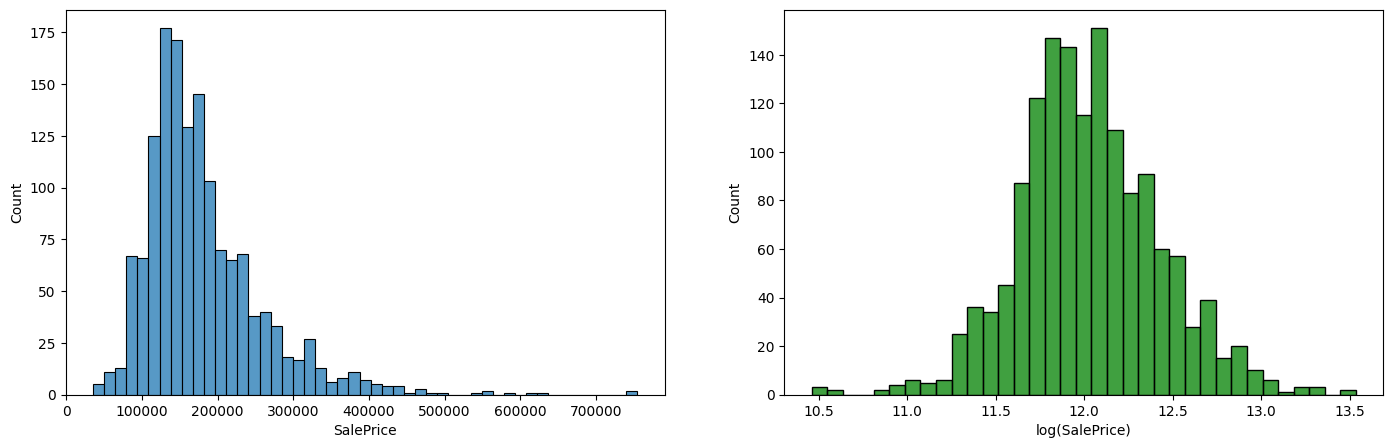

In [129]:
y_log = np.log(y)

plt.figure(figsize=(17, 5))

plt.subplot(1, 2, 1)
sns.histplot(y)

plt.subplot(1, 2, 2)
sns.histplot(y_log, color='green')

plt.xlabel("log(SalePrice)")

In [ ]:
# Create your new scorer to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

## 2.2 Model Iteration ♻

#### a) Final Version of the Preproc Pipeline
❓We advise you to start with a fresh definition below so you can quickly update it as needed and then try many model types to find the best one possible (you can try GridSearch or go model by model)

##### Searching for model params

In [55]:
forest = RandomForestRegressor()
lin_reg = LinearRegression()
knn = KNeighborsRegressor()
ridge = Ridge()
adaboost = AdaBoostRegressor()
gradientboost = GradientBoostingRegressor()
svm_reg = SVR()

In [56]:
forest_params = {
    'n_estimators': [100, 150, 200, 250, 300, 400, 450, 500],
    'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'min_samples_split':[2, 3, 4, 5, 6],
    'min_samples_leaf':[1, 2, 3, 4, 5]
    }

lin_reg_params = {'n_jobs':np.arange(1,20)}

knn_params = {
    'n_neighbors': np.arange(2, 30, dtype=int),
    'algorithm':['auto', 'ball_tree', 'kd_tree','brute'], 
    'leaf_size': np.arange(30, 101, 10, dtype=int),
    'p': np.linspace(1, 10)
}

ridge_params = {
    'alpha': np.logspace(-3, 3, 10),
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

adaboost_params = {
    'learning_rate': np.linspace(1, 10)
}

gradientboost_params ={
    'learning_rate': np.linspace(1, 10),
    'min_samples_split': [2, 3, 4, 5, 6], 
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
}

svm_reg_params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree' : np.arange( 0, 100+0, 1 ).tolist(), 
    "C": np.logspace(-3, 3, 10),
    "gamma" : np.logspace(-3, 2, 6),
    "coef0" : np.arange( 0.0, 10.0+0.0, 0.1 ).tolist(),
    'epsilon': np.linspace(0,1,1)
}

In [50]:
def best_model(estimator, params, X, y):
    '''
    Returns a fitted model from a RandomizedSearchCV.
    
    ---------(\ parameters )\----------
    
    '''
    search = RandomizedSearchCV(
                estimator,
                params, 
                scoring = 'neg_mean_squared_log_error',
                cv = 5,
                random_state=42,
                n_jobs=-1, # parallelize computation
                error_score = 'raise') 

    return search.fit(X, y)
#helper function for random searching models excluding xgboost and lin_reg
def search_estimators(list_estimators, list_params, X, y):
    best_estimators = []
    for estimator, params in zip(list_estimators, list_params):
        result = best_model(estimator, params, X, y)
        
        best_estimator_info = result.best_estimator_
        estimator_score = result.best_score_
        
        model_info = {estimator: [best_estimator_info, estimator_score]}
        best_estimators.append(model_info)
            
    return best_estimators

In [ ]:
# %%time
# #list of models
# model_list = [forest, ridge, svm_reg]

# #list of search_parameters
# search_params = [forest_params, ridge_params, svm_reg_params]

# best_estimator_params_score = search_estimators(model_list, search_params, X_preprocess, y)
# best_estimator_params_score

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(X_preprocess, y, test_size=0.3, random_state=42)

In [ ]:
# %%time
# xgb_search = RandomizedSearchCV(
#                 xgb_reg,
#                 xgb_reg_params, 
#                 scoring = 'r2',
#                 cv = 5,
#                 random_state=42,
#                 n_jobs=-1, # parallelize computation
#                 error_score = 'raise',
#                 n_iter=10
#             ) 

# xgb_search.fit(X_train, y_train,
#               eval_set=[(X_train, y_train),(X_val, y_val)])

##### xgboost

In [62]:
cv

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)

In [192]:
y_log = np.log(y)
#Hold-out
X_train, X_test, y_train, y_test = train_test_split(X_preprocess, y_log, test_size=0.3, random_state=42 )

###### fine tuning regressors

In [190]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 800),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 100)
    }
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [194]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='3rd_trial')
study.optimize(objective, n_trials=20)

[I 2023-12-10 05:05:38,643] A new study created in memory with name: 3rd_trial
[I 2023-12-10 05:05:41,747] Trial 0 finished with value: 0.02751446182857867 and parameters: {'max_depth': 7, 'learning_rate': 0.5843880317879876, 'n_estimators': 449, 'min_child_weight': 2, 'gamma': 0.6790730586629677, 'subsample': 0.21228070750145178, 'colsample_bytree': 0.5613842160118251, 'reg_alpha': 0.21160721109629235, 'reg_lambda': 0.3294916531092156, 'random_state': 13}. Best is trial 0 with value: 0.02751446182857867.
[I 2023-12-10 05:05:42,232] Trial 1 finished with value: 0.034278195634207934 and parameters: {'max_depth': 5, 'learning_rate': 0.8008118612799219, 'n_estimators': 141, 'min_child_weight': 8, 'gamma': 0.6820771385454814, 'subsample': 0.7428256727356781, 'colsample_bytree': 0.788937595298212, 'reg_alpha': 0.24291497338996454, 'reg_lambda': 0.5929342454898389, 'random_state': 53}. Best is trial 0 with value: 0.02751446182857867.
[I 2023-12-10 05:05:44,142] Trial 2 finished with value: 0

In [195]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 2, 'learning_rate': 0.23461471834797526, 'n_estimators': 193, 'min_child_weight': 6, 'gamma': 0.28344694493593936, 'subsample': 0.572083596925999, 'colsample_bytree': 0.8200241759784761, 'reg_alpha': 0.3544072465482201, 'reg_lambda': 0.9997133072112757, 'random_state': 45}


###### fine tuning classifiers

In [91]:
def objective_function(params):
    xgb_reg = XGBRegressor(**params)
    score = cross_val_score(xgb_reg, X_train, y_train, cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42)).mean()
    return {'loss': -score, 'status': STATUS_OK}    

In [96]:
space= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 5, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 100),
    'max_leaves': hp.quniform('max_leaves', 5, 50, 1),
    'boosting_type': hp.choice('boosting_type', ['gbtree', 'dart']),
    'tree_method': hp.choice('tree_method', ['auto', 'exact', 'approx', 'hist', 'gpu_hist']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma': hp.loguniform('gamma', np.log(0.01), np.log(1)),
    'max_delta_step': hp.quniform('max_delta_step', 1, 9, 1)
}

In [100]:
tpe_algorithm = tpe.suggest
trials = Trials()
num_eval = 1022
seed_value = 42
rng = np.random.default_rng(seed_value)

In [101]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [104]:
'''only works for classification models'''
# best_param = fmin(objective_function, 
#                   space, 
#                   algo=tpe.suggest, 
#                   max_evals=num_eval, 
#                   trials=trials, 
#                   rstate= rng,
#                   trials_save_file=out_file
#                  )

'only works for classification models'

###### final xgboost

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocess, y_log, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

###### random search

In [116]:
xgb_reg = XGBRegressor(**study.best_params, early_stopping_rounds=5) #--> this shit does not seem to like me at all

xgb_reg_params = {
    'booster': ['gbtree', 'dart'], 
    'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
}

search_xgb = RandomizedSearchCV(
                xgb_reg,
                xgb_reg_params, 
                scoring = 'neg_mean_squared_log_error',
                cv = 5,
                random_state=42,
                n_jobs=-1, # parallelize computation
                error_score = 'raise') 

fitted_search_xgb = search_xgb.fit(X_train, y_train,
                                  eval_set=[(X_train, y_train), (X_val, y_val)]
                                  )

[0]	validation_0-rmse:10.57794	validation_1-rmse:10.52889
[1]	validation_0-rmse:9.70108	validation_1-rmse:9.65206
[2]	validation_0-rmse:8.89491	validation_1-rmse:8.84593
[3]	validation_0-rmse:8.15713	validation_1-rmse:8.10820
[4]	validation_0-rmse:7.47960	validation_1-rmse:7.43072
[5]	validation_0-rmse:6.85965	validation_1-rmse:6.81081
[6]	validation_0-rmse:6.29119	validation_1-rmse:6.24241
[7]	validation_0-rmse:5.76975	validation_1-rmse:5.72104
[8]	validation_0-rmse:5.29225	validation_1-rmse:5.24362
[0]	validation_0-rmse:10.57874	validation_1-rmse:10.52969
[9]	validation_0-rmse:4.85344	validation_1-rmse:4.80782
[0]	validation_0-rmse:10.57711	validation_1-rmse:10.52806
[1]	validation_0-rmse:9.70082	validation_1-rmse:9.65180
[0]	validation_0-rmse:10.57794	validation_1-rmse:10.52889
[1]	validation_0-rmse:9.69767	validation_1-rmse:9.64865
[10]	validation_0-rmse:4.45209	validation_1-rmse:4.40874
[2]	validation_0-rmse:8.89584	validation_1-rmse:8.84686
[2]	validation_0-rmse:8.89119	validatio

###### best_model

In [117]:
fitted_search_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8675264919050718, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None,
             gamma=0.03260544680962653, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.08329571318911909, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=970, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=261, reg_alpha=0.8007165124021263,
             reg_lambda=0.6109981963702018, ...)

In [119]:
fitted_search_xgb.best_params_

{'tree_method': 'auto', 'booster': 'dart'}

##### final pipe

In [145]:
#finetuned models
tuned_forest = RandomForestRegressor(max_depth=10, min_samples_split=6, n_estimators=450)
tuned_lin_reg = LinearRegression(n_jobs=1)
# tuned_knn = KNeighborsRegressor(algorithm='ball_tree', leaf_size=70, n_neighbors=3, p=1.0)
tuned_ridge = Ridge(alpha=10.0, solver='lsqr')
# tuned_adaboost = AdaBoostRegressor(learning_rate=3.3877551020408165)
# tuned_gradientboost = GradientBoostingRegressor(learning_rate=1.183673469387755, max_depth=10, min_samples_leaf=4, min_samples_split=3)
tuned_svm_reg = SVR(C=1000.0, coef0=3.1, epsilon=0.0, gamma=10.0, kernel='poly')
# tuned_svm_reg_2 = SVR(C=1000.0, coef0=2.8000000000000003, degree=78, epsilon=0.0, gamma=1.0, kernel='linear')

In [ ]:
#Multilayer stacking
stacking_reg = StackingRegressor(estimators=[
                                       ('rg', tuned_ridge),
                                       ('svm', tuned_svm_reg)
                                      ],
                                 final_estimator=tuned_forest,
                                 passthrough=True
                          )


##### xgboost pipe

In [133]:
xgb_reg = XGBRegressor(max_depth=10, 
                       learning_rate=0.08329571318911909,
                       n_estimators=970, 
                       min_child_weight=8, 
                       gamma=0.03260544680962653, 
                       subsample=0.5184557837483537, 
                       colsample_bytree=0.8675264919050718, 
                       reg_lambda=0.6109981963702018, 
                       random_state=261,
                       booster='dart'
                      ) 

In [149]:
xgb_pipe = make_pipeline(preproc, 
                         xgb_reg
                             )

In [187]:
xgb_reg_2 = XGBRegressor(**study.best_params) 

In [196]:
xgb_reg_3 = XGBRegressor(**study.best_params) 

In [197]:
xgb_pipe_3 = make_pipeline(preproc, 
                         xgb_reg_3
                             )

score_xgb = cross_val_score(xgb_pipe_2, X, y, cv=5, scoring=rmsle, error_score='raise').mean()

In [198]:
score_xgb

0.12966811753741325

#### Best Pipe 1: svm ver 1

In [ ]:
stacking_pipe = make_pipeline(preproc, 
                             stacking_reg
                             )

stacking_pipe.fit(X,y)

In [ ]:
#checking the scores
score_stacking = cross_val_score(stacking_pipe, X, y, cv=5, scoring=rmsle, error_score='raise').mean()

In [ ]:
score_stacking

#### Best Pipe 2: svm ver 2

In [ ]:
# stacking_pipe_2 = make_pipeline(preproc, 
#                              stacking_reg_2
#                              )

# stacking_pipe.fit(X,y)

In [ ]:
# score_stacking_2 = cross_val_score(stacking_pipe_2, X, y, cv=5, scoring=rmsle, error_score='raise').mean()

In [ ]:
# score_stacking_2

##### Multi_pipe

In [ ]:
stacking_pipe_multi = make_pipeline(preproc_multi, 
                             stacking_reg
                             )

stacking_pipe_multi.fit(X,y)

In [ ]:
score_multi = cross_val_score(stacking_pipe_multi, X, y, cv=5, scoring=rmsle, error_score='raise').mean()

In [ ]:
score_multi

In [ ]:
# stacking_pipe_custom = make_pipeline(preproc_select, 
#                              stacking_reg
#                              )

# stacking_pipe_multi.fit(X,y)

In [ ]:
# score_custom = cross_val_score(stacking_pipe_custom, X, y, cv=5, scoring=rmsle, error_score='raise').mean()

In [ ]:
# score_custom

# 🏅FINAL SUBMISSION (submit at leaspreproc_multifore Recap)

Discover your real test score by submitting to Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [176]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

In [178]:
# Adding columns to X_test according to what we did to X
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test_MoSold = X_test.drop(columns=['MoSold'])

In [ ]:
# stacking_pipe.fit(X, y_log)

# predictions_log = stacking_pipe.predict(X_test)
# predictions = np.exp(predictions_log)

In [173]:
xgb_pipe_2.fit(X, y_log)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f04dcc1a890>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='NA',
                                                                                                  st...
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.028945973428853612, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=7, max_leaves=0, min_child_weight=3,
                              missing=nan, monotone_constraints='()',
                              n_estimators=466, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=770,
                              reg_alpha=0.2970182551446406,
                              reg_lambda=0.4320099988447804, ...))])

In [179]:
xgb_pred_2 = xgb_pipe_2.predict(X_test)
xgb_preds_2 = np.exp(xgb_pred_2)

In [ ]:
# results = pd.concat([X_test_ids, pd.Series(predictions, name="SalePrice")], axis=1)
# results

In [180]:
results = pd.concat([X_test_ids, pd.Series(xgb_preds, name="SalePrice")], axis=1)
results

,Id,SalePrice
0,1461,125586.781250
1,1462,166059.375000
2,1463,189328.031250
3,1464,194487.000000
4,1465,197575.718750
...,...,...
1454,2915,78739.632812
1455,2916,86314.437500
1456,2917,166195.296875
1457,2918,112658.593750


In [181]:
# Export to Kaggle format submission and submit it online!
results.to_csv("submission_final_6.csv", header=True, index=False)